
# Setting Google drive

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"majdalotaibi","key":"8b788d2d31ab0efc12b7bbc5bf75bf5b"}'}

In [2]:
!pip install -U opendatasets -q
import opendatasets
opendatasets.download('https://www.kaggle.com/datasets/msambare/fer2013')

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013


# Importing the Libraries

In [3]:
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Loading the Dataset & Labeling

In [4]:
# All Folders

# base_path = '/content/fer2013'

# def create_dataframe(split):
#     data = []
#     split_path = os.path.join(base_path, split)

#     for label in os.listdir(split_path):
#         label_path = os.path.join(split_path, label)

#         if os.path.isdir(label_path):
#             for img_file in os.listdir(label_path):
#                 img_path = os.path.join(label_path, img_file)
#                 data.append([img_path, label])

#     return pd.DataFrame(data, columns=['image_path', 'label'])

# train_df = create_dataframe('train')
# test_df = create_dataframe('test')

# just spesfics Folders


base_path = '/content/fer2013'
allowed_labels = {'happy', 'angry', 'neutral','sad'}

def create_dataframe(split):
    data = []
    split_path = os.path.join(base_path, split)

    for label in os.listdir(split_path):
        if label not in allowed_labels:
            continue

        label_path = os.path.join(split_path, label)

        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                data.append([img_path, label])

    return pd.DataFrame(data, columns=['image_path', 'label'])

train_df = create_dataframe('train')
test_df = create_dataframe('test')

# Dataset Exploration

In [11]:
train_df.head()

,image_path,label
0,/content/fer2013/train/angry/Training_13742442...,angry
1,/content/fer2013/train/angry/Training_99547128...,angry
2,/content/fer2013/train/angry/Training_94409693...,angry
3,/content/fer2013/train/angry/Training_38334419...,angry
4,/content/fer2013/train/angry/Training_93769668...,angry


In [12]:
train_df.shape

(15980, 2)

In [13]:
train_df['label'].value_counts()

,count
label,
angry,3995
happy,3995
neutral,3995
sad,3995


In [14]:
import pandas as pd

min_count = train_df['label'].value_counts().min()

train_df = (
    train_df
    .groupby('label')
    .apply(lambda x: x.sample(n=min_count, random_state=42))
    .reset_index(drop=True)
)


train_df['label'].value_counts()

<ipython-input-14-e7159fe61b30>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_count, random_state=42))


,count
label,
angry,3995
happy,3995
neutral,3995
sad,3995


In [15]:
test_df.shape

(5212, 2)

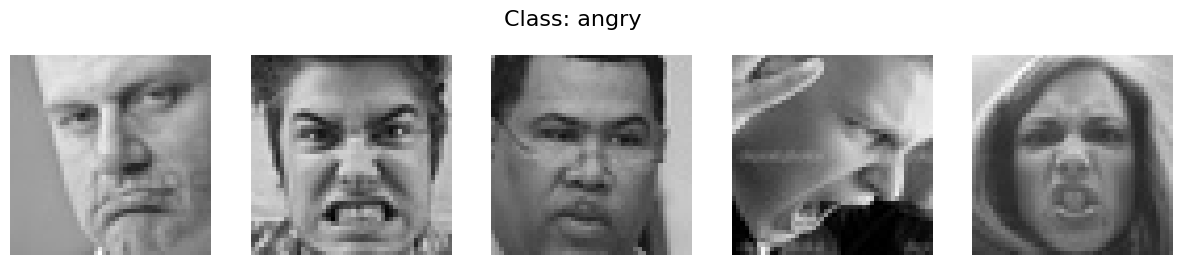

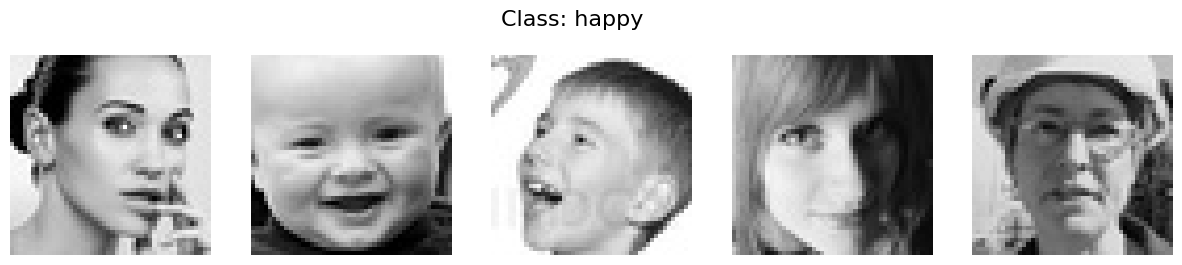

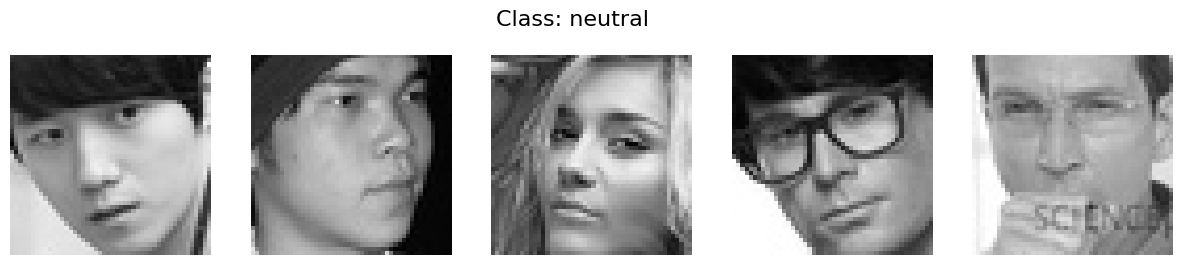

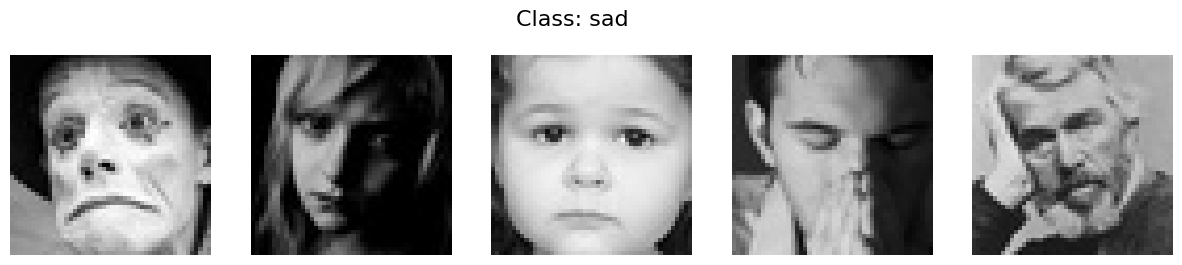

In [16]:
classes = train_df['label'].unique()

for label in classes:
    subset = train_df[train_df['label'] == label].head(5)

    plt.figure(figsize=(15, 3))
    plt.suptitle(f'Class: {label}', fontsize=16)

    for i, row in enumerate(subset.itertuples(), 1):
        img = cv2.imread(row.image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 5, i)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

# Data Splitting

In [17]:
new_train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['label'],
    random_state=42
)

print("New train shape:", new_train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

New train shape: (12784, 2)
Validation shape: (3196, 2)
Test shape: (5212, 2)


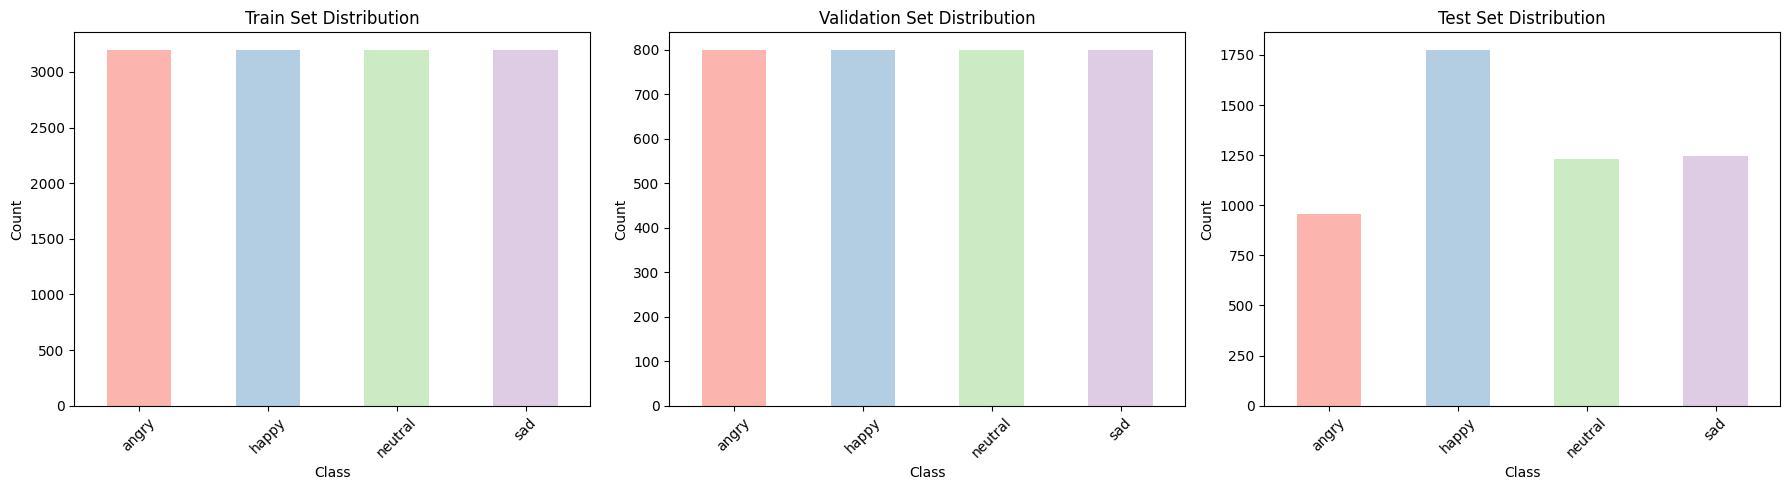

In [18]:
distributions = {
    'Train Set': new_train_df['label'].value_counts().sort_index(),
    'Validation Set': val_df['label'].value_counts().sort_index(),
    'Test Set': test_df['label'].value_counts().sort_index()
}

labels = sorted(set().union(*[dist.index for dist in distributions.values()]))

colors = list(plt.cm.Pastel1.colors)

plt.figure(figsize=(18, 5))
for i, (title, dist) in enumerate(distributions.items(), 1):
    plt.subplot(1, 3, i)
    dist = dist.reindex(labels, fill_value=0)
    dist.plot(kind='bar', color=colors[:len(labels)])
    plt.title(f'{title} Distribution')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.xlabel('Class')

plt.tight_layout()
plt.show()


# Data Augmentation

In [19]:
WIDTH, HEIGHT = 48, 48
batch_size = 64

# train_datagen = ImageDataGenerator(
#     rotation_range=15,
#     rescale=1./255,
#     shear_range=0.1,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     width_shift_range=0.1,
#     height_shift_range=0.1
# )
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=new_train_df,
    x_col='image_path',
    y_col='label',
    target_size=(WIDTH, HEIGHT),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(WIDTH, HEIGHT),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(WIDTH, HEIGHT),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 12784 validated image filenames belonging to 4 classes.
Found 3196 validated image filenames belonging to 4 classes.
Found 5212 validated image filenames belonging to 4 classes.


In [20]:
train_generator.class_indices

{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3}

# Building the CNN Model

In [23]:
import gc
import tensorflow as tf
tf.keras.backend.clear_session()
gc.collect()


0

In [21]:
model = Sequential([
    Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    # Conv2D(64, kernel_size=(3, 3), activation='relu'),
    # Conv2D(256, kernel_size=(3, 3), activation='relu'),
    # MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    #2
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    # Dense(16, activation='relu'),
    #2
    Dropout(0.5),
    Dense(4, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## EXP 2

In [27]:
model = Sequential([
    Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(10, activation='relu'),
    Dense(4, activation='softmax')
])

In [28]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,742 (401.34 KB)

 Trainable params: 102,198 (399.21 KB)

 Non-trainable params: 544 (2.12 KB)

# Compiling the Model

In [29]:
# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )
from tensorflow.keras.optimizers import AdamW
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model.compile(
    loss='categorical_crossentropy',
    # optimizer=Adam(lr=0.0001, decay=1e-6),
    # optimizer=Adam(learning_rate=0.001),
    optimizer=AdamW(learning_rate=0.001, weight_decay=1e-4),
    # optimizer=AdamW(),
    # optimizer='rmsprop',
    metrics=['accuracy']
)

# Training the Model

In [30]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.3011 - loss: 1.5903 - val_accuracy: 0.2922 - val_loss: 1.3839
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.3679 - loss: 1.3468 - val_accuracy: 0.3436 - val_loss: 1.3345
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.4266 - loss: 1.2491 - val_accuracy: 0.4496 - val_loss: 1.1989
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.4944 - loss: 1.1551 - val_accuracy: 0.3946 - val_loss: 1.3046
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5107 - loss: 1.1011 - val_accuracy: 0.5016 - val_loss: 1.1185
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5469 - loss: 1.0559 - val_accuracy: 0.5407 - val_loss: 1.0523
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5777 - loss: 1.0004 - val_accuracy: 0.5613 - val_loss: 1.0081
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6063 - loss: 0.9594 -

In [31]:
model.save('modal75.h5')